In [27]:
import seaborn as sns
import pandas as pd
import numpy as np
import json
import glob
import re

In [28]:
folder = "logs/00_initial"

lines = []
for file_name in glob.glob("*.log", root_dir=folder):
    with open(folder + "/" + file_name) as f:
        while line := f.readline():
            if "PFSTT" in line:
                json_string = re.search(r'PFSTT(.*?)TTSFP', line).group(1)
                lines.append(json.loads(json_string))

df = pd.DataFrame(lines)
# Set Data Types
df["start"] = df["start"].astype(float)
df["end"] = df["end"].astype(float)
df["request_timestamp"] = df["request_timestamp"].astype(float)
df["request_deadline"] = df["request_deadline"].astype(float)

# Calculate Durations
min_timestamp = df["request_timestamp"].min()
last_experiment_timestamp = df["end"].max()
df["request_timestamp"] = df["request_timestamp"] - min_timestamp
df["request_deadline"] = df["request_deadline"] - min_timestamp
df["start"] = df["start"] - min_timestamp
df["end"] = df["end"] - min_timestamp

# Add new columns
df["run_duration"] = df["end"] - df["start"]
df["time_to_deadline"] = df["request_deadline"] - df["start"]
df["init_duration"] = df["start"] - df["request_timestamp"]
df

,function,start,end,request_timestamp,request_deadline,mode,run_duration,time_to_deadline,init_duration
0,check,1.022837e+04,1.044250e+04,2597.0,32597.0,bored,214.135986,22368.632080,7631.367920
1,check,1.044553e+04,1.050015e+04,0.0,30000.0,bored,54.615479,19554.465820,10445.534180
2,check,1.050167e+04,1.056635e+04,520.0,30520.0,bored,64.676514,20018.331055,9981.668945
3,check,1.056732e+04,1.063878e+04,1393.0,31393.0,bored,71.466553,20825.683594,9174.316406
4,check,1.063980e+04,1.069669e+04,1927.0,31927.0,bored,56.888916,21287.198486,8712.801514
...,...,...,...,...,...,...,...,...,...
132,ocr,1.403180e+06,1.417011e+06,1319641.0,1319641.0,bored,13831.048340,-83538.944824,83538.944824
133,ocr,1.417018e+06,1.431287e+06,1319755.0,1319755.0,bored,14269.358154,-97263.101074,97263.101074
134,ocr,1.431291e+06,1.444953e+06,1319860.0,1319860.0,bored,13662.342041,-111430.771729,111430.771729
135,ocr,1.444954e+06,1.458188e+06,1332552.0,1332552.0,bored,13233.735840,-112402.343018,112402.343018


In [33]:
# If you want all CPU usage values in the df set this to False
ONLY_RELEVANT_CPU = True

smaller_dfs = []
for file_name in glob.glob("*.csv", root_dir="usage/"):
    if ONLY_RELEVANT_CPU:
        start_ts = int(file_name.split("_")[3])
        if start_ts > last_experiment_timestamp or start_ts < min_timestamp - 1000*60*60*24:
            continue
    with open("usage/" + file_name) as f:
        smaller_dfs.append(pd.read_csv(f))
usage_df = pd.concat(smaller_dfs)
usage_df["experiment_time"] = usage_df["unix_time"] - min_timestamp

if ONLY_RELEVANT_CPU:
    # Delete all values 10 seconds after the last call ended and 10 seconds before the first call started
    usage_df = usage_df[usage_df["experiment_time"] <= (last_experiment_timestamp + 10000)]
    usage_df = usage_df[usage_df["experiment_time"] >= (min_timestamp - 10000)]

usage_df

,unix_time,cpu_percent,ram_percent,experiment_time
0,1694792374381,16,53.25,88464327.0
1,1694792376395,14,53.24,88466341.0
2,1694792378409,13,53.17,88468355.0
3,1694792380425,19,52.99,88470371.0
4,1694792382433,27,53.36,88472379.0
5,1694792384446,18,53.55,88474392.0
6,1694792386460,18,53.61,88476406.0
7,1694792388475,20,53.76,88478421.0
8,1694792390490,14,53.73,88480436.0
9,1694792392505,14,53.62,88482451.0


/home/trever/.local/share/virtualenvs/stats-94myh5A0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/trever/.local/share/virtualenvs/stats-94myh5A0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/trever/.local/share/virtualenvs/stats-94myh5A0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/trever/.local/share/virtualenvs/stats-94myh5A0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

<Axes: xlabel='request_timestamp', ylabel='run_duration'>

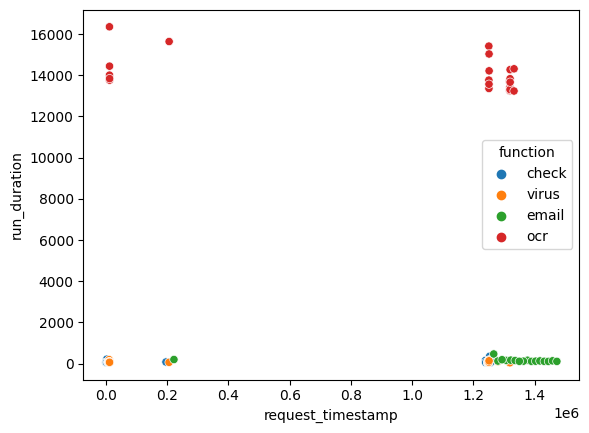

In [30]:
sns.scatterplot(data=df, x="request_timestamp", y="run_duration", hue="function")

/home/trever/.local/share/virtualenvs/stats-94myh5A0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/trever/.local/share/virtualenvs/stats-94myh5A0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/trever/.local/share/virtualenvs/stats-94myh5A0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/trever/.local/share/virtualenvs/stats-94myh5A0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

<Axes: xlabel='request_timestamp', ylabel='run_duration'>

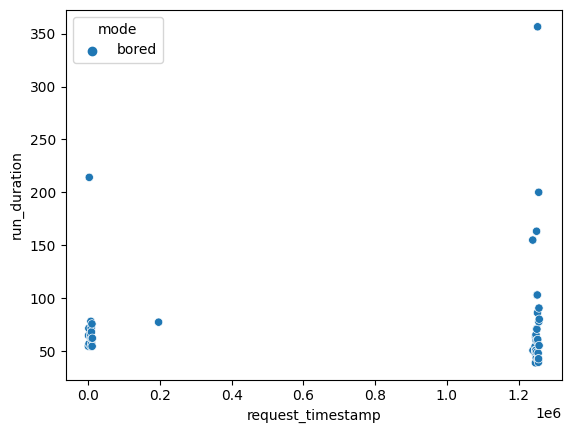

In [31]:
sns.scatterplot(data=df[df["function"] == "check"], x="request_timestamp", y="run_duration", hue="mode")

/home/trever/.local/share/virtualenvs/stats-94myh5A0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/trever/.local/share/virtualenvs/stats-94myh5A0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/trever/.local/share/virtualenvs/stats-94myh5A0/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/trever/.local/share/virtualenvs/stats-94myh5A0/lib/python3.11/site-packages/seaborn/_oldcore.py:111

<Axes: xlabel='experiment_time', ylabel='cpu_percent'>

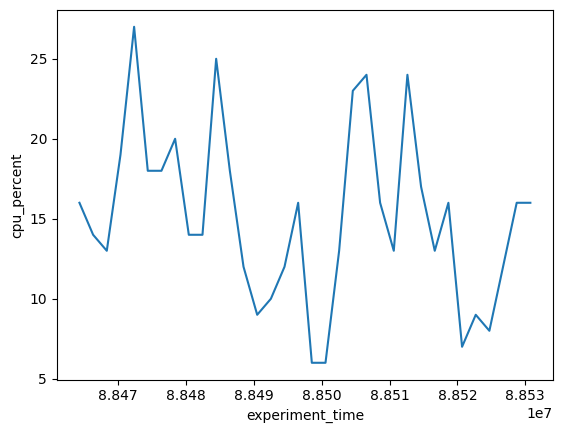

In [36]:
sns.lineplot(data=usage_df, x="experiment_time", y="cpu_percent")